In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer
# For dimensionality reduction
from umap import UMAP
# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# For handling warnings
import warnings
warnings.filterwarnings('ignore')

2024-10-27 08:07:49.650497: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 08:07:49.849706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 08:07:49.851263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 08:07:50.748461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
column_n = ['news_id', 'category', 'subcategory', 'Title', 'Abstract', 'url', 'TitleEnt', 'AbstractEnt']
column_b = ['ImpressionId', 'user_id', 'timestamps', 'history', 'impressions']
news_df  = pd.read_csv('data/news.tsv', sep='\t', header=None, names=column_n)
behaviors_df= pd.read_csv('data/behaviors.tsv', sep='\t', header=None, names=column_b)

In [126]:
behaviors_df = behaviors_df.sample(frac=0.1, random_state=42)

In [130]:
behaviors_df.shape

(15696, 6)

In [132]:
# Fill NaN values in 'Title' and 'Abstract' with empty strings
news_df['Title'] = news_df['Title'].fillna('')
news_df['Abstract'] = news_df['Abstract'].fillna('')
behaviors_df['history'] = behaviors_df['history'].fillna('')

In [134]:
#Extract User Histories
# Split the 'history' string into a list of news_ids
behaviors_df['history_list'] = behaviors_df['history'].apply(lambda x: x.split(' ') if x != '' else [])


In [136]:
# Create a mapping from news_id to category
news_category_map = news_df.set_index('news_id')['category'].to_dict()

In [138]:
from tqdm import tqdm
from collections import Counter


# Initialize a list to store user-category interactions
user_category_data = []

# Iterate over each user's history
for idx, row in tqdm(behaviors_df.iterrows(), total=behaviors_df.shape[0]):
    user_id = row['user_id']
    history = row['history_list']
    categories = [news_category_map.get(news_id, 'Unknown') for news_id in history]
    category_counts = Counter(categories)
    category_counts['user_id'] = user_id
    user_category_data.append(category_counts)

# Create DataFrame
user_category_df = pd.DataFrame(user_category_data)
user_category_df = user_category_df.fillna(0)

100%|██████████| 15696/15696 [00:00<00:00, 18877.73it/s]


In [140]:
# Separate user_id from features
user_ids = user_category_df['user_id']
features = user_category_df.drop('user_id', axis=1)

In [142]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [144]:
features_scaled

array([[ 0.80547659, -0.07394547,  1.08477729, ..., -0.37160386,
        -0.01706848, -0.01128881],
       [-0.41748773, -0.64527114, -0.62200439, ..., -0.37160386,
        -0.01706848, -0.01128881],
       [-0.41748773, -0.3596083 , -0.62200439, ..., -0.37160386,
        -0.01706848, -0.01128881],
       ...,
       [-0.17289487, -0.3596083 , -0.05307716, ..., -0.37160386,
        -0.01706848, -0.01128881],
       [-0.41748773, -0.64527114, -0.43236198, ..., -0.37160386,
        -0.01706848, -0.01128881],
       [-0.17289487, -0.07394547, -0.05307716, ..., -0.37160386,
        -0.01706848, -0.01128881]])

In [146]:
# Basic initialization with 2 components (2D projection)
umap_model = UMAP(n_components=2, random_state=42)


In [287]:
umap_transformed 

array([[ 3.3630183,  2.0501857],
       [ 2.7009158, 12.786791 ],
       [ 7.1453466, -1.8732878],
       ...,
       [ 5.4982524, -4.070088 ],
       [10.03141  , -0.2756827],
       [10.497149 ,  0.5194488]], dtype=float32)

In [242]:
umap_model = UMAP(n_components=2, n_neighbors=10, min_dist=0.1, random_state=42)
umap_model_5 = UMAP(n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)
umap_model_10 = UMAP(n_components=2, n_neighbors=10, min_dist=0.2, random_state=42)
umap_model_15 = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_model_20 = UMAP(n_components=2, n_neighbors=20, min_dist=0.1, random_state=42)

In [244]:
umap_transformed = umap_model.fit_transform(features_scaled)
umap_transformed_5 = umap_model_5 .fit_transform(features_scaled)
umap_transformed_10 = umap_model_10.fit_transform(features_scaled)
umap_transformed_15 = umap_model_15.fit_transform(features_scaled)
umap_transformed_20 = umap_model_20.fit_transform(features_scaled)

In [252]:
# Convert UMAP result to DataFrame
umap_df = pd.DataFrame(umap_transformed, columns=['UMAP1', 'UMAP2'])
umap_df_10 = pd.DataFrame(umap_transformed_10, columns=['UMAP1', 'UMAP2'])

In [290]:
umap_df

,UMAP1,UMAP2,Cluster
0,3.363018,2.050186,6
1,2.700916,12.786791,9
2,7.145347,-1.873288,7
3,7.769857,1.155429,1
4,12.245392,-1.209895,7
...,...,...,...
15691,3.553489,5.523447,7
15692,4.748424,5.176386,2
15693,5.498252,-4.070088,7
15694,10.031410,-0.275683,0


In [246]:
# Save the PCA DataFrame with cluster labels to CSV
umap_df.to_csv('umap_df.csv', index=False)

In [272]:
#from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust n_clusters as needed
umap_clusters_10 = kmeans.fit_predict(umap_transformed_10)

# Add cluster labels to DataFrame (if needed for further analysis)
umap_df_10['Cluster'] = umap_clusters_10

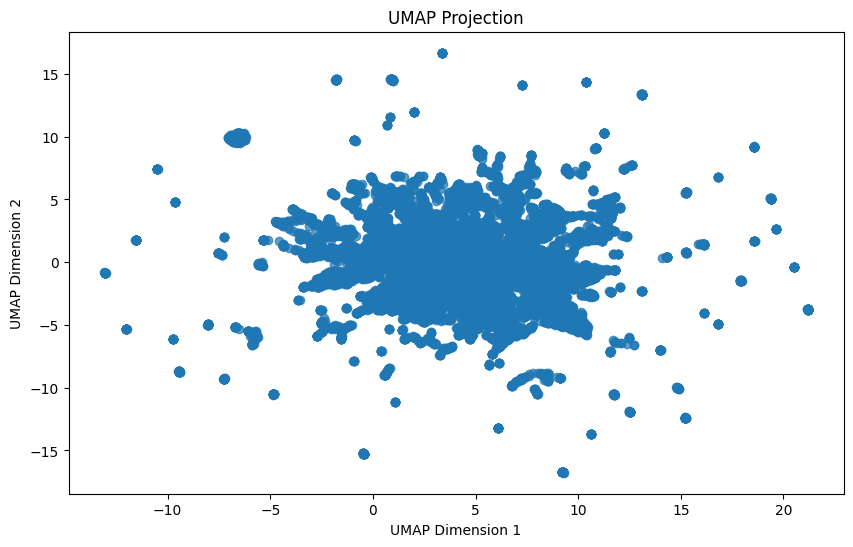

In [262]:
plt.figure(figsize=(10, 6))
plt.scatter(umap_df_10['UMAP1'], umap_df_10['UMAP2'], alpha=0.7, cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection')
plt.show()

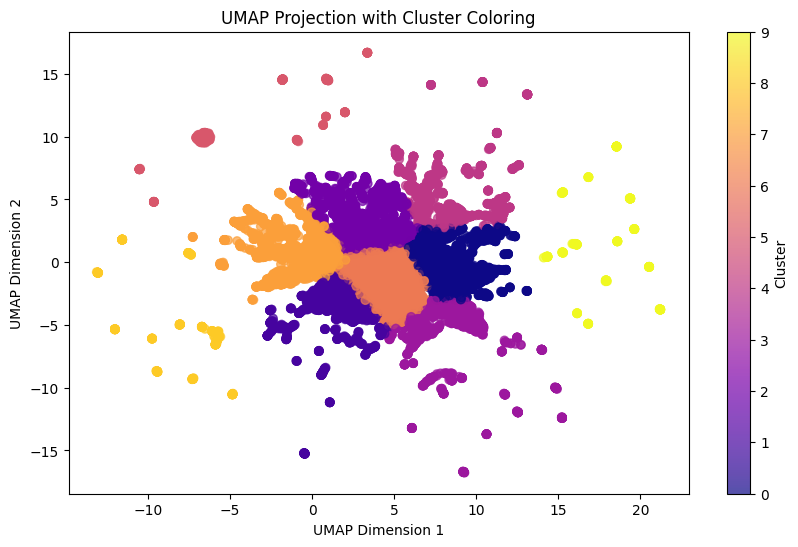

In [274]:
plt.figure(figsize=(10, 6))
plt.scatter(umap_df_10['UMAP1'], umap_df_10['UMAP2'], c= umap_df_10['Cluster'], cmap='plasma', alpha=0.7)  # Color by 'Cluster'
plt.colorbar(label='Cluster')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection with Cluster Coloring')
plt.show()


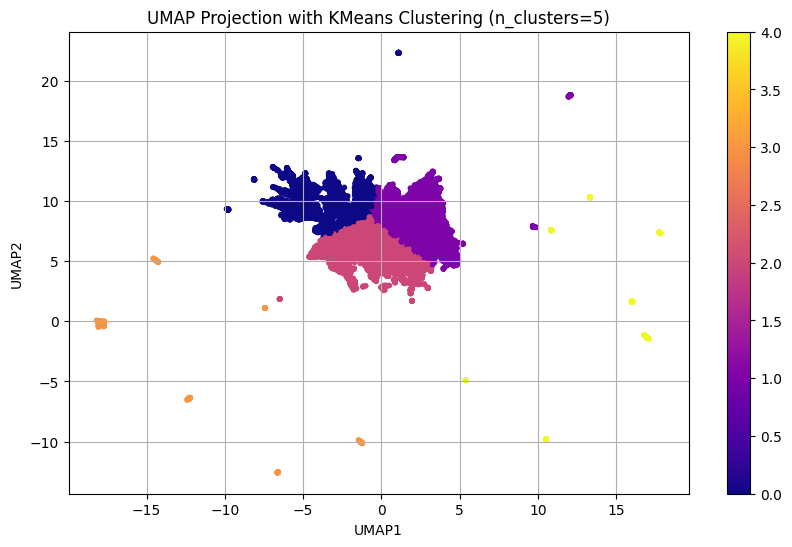

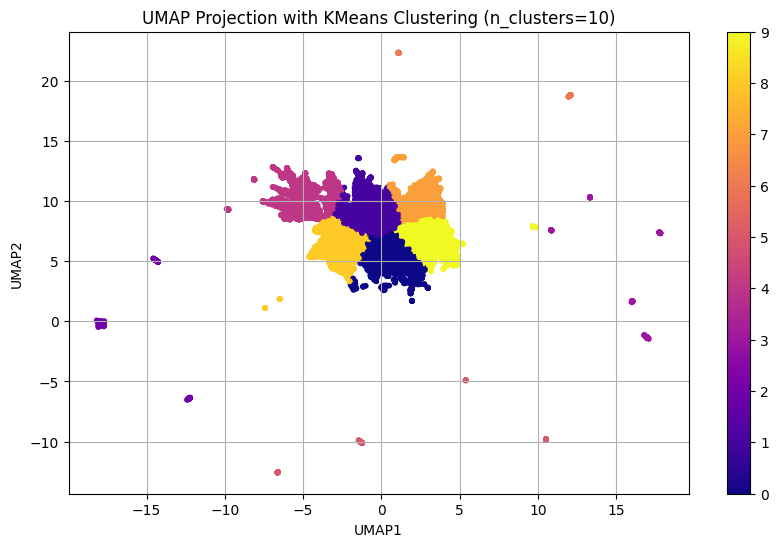

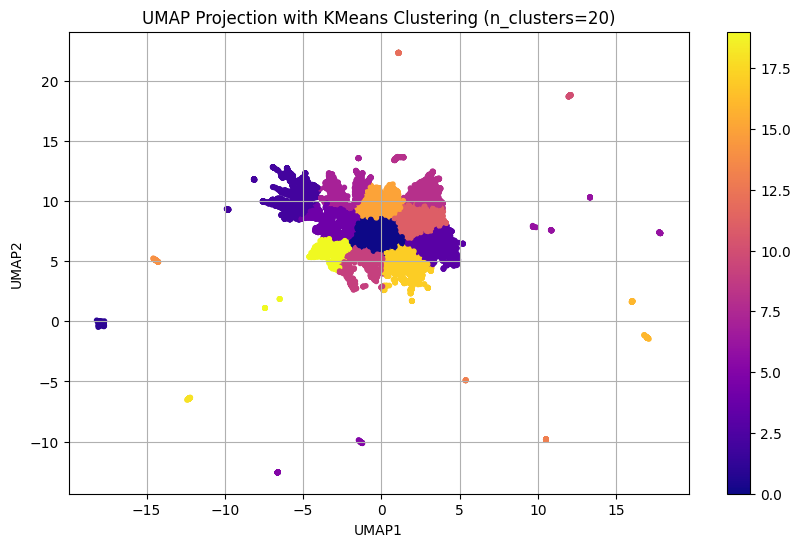

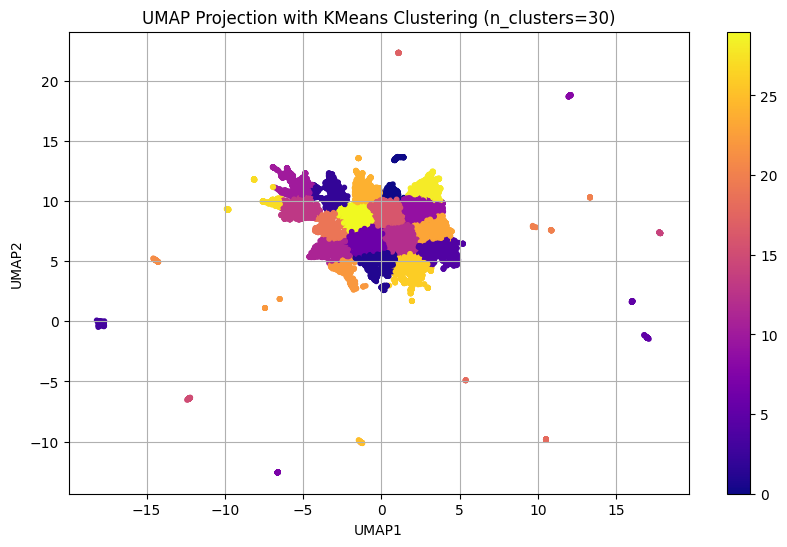

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap

def plot_umap_with_clusters(X, n_clusters_list, n_neighbors=15, n_components=2):
    # Apply UMAP once to reduce dimensionality
    for n_neighbour in n_neighbors:
        reducer = umap.UMAP(n_neighbors=n_neighbour, n_components=n_components, min_dist=0.1,random_state=42)
        umap_transformed = reducer.fit_transform(X)
        # Create a DataFrame to store UMAP results
        umap_df = pd.DataFrame(umap_transformed, columns=['UMAP1', 'UMAP2'])
    
    # Loop over each n_clusters value, apply KMeans, and plot the clusters
    for n_clusters in n_clusters_list:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        umap_df['Cluster'] = kmeans.fit_predict(umap_transformed)
        
        # Plot the UMAP projection with clusters
        plt.figure(figsize=(10, 6))
        plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df['Cluster'], cmap='plasma', s=10)
        plt.colorbar()
        plt.title(f'UMAP Projection with KMeans Clustering (n_clusters={n_clusters})')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.grid()
        plt.show()

# Example usage
# X = np.random.rand(1000, 50)  # replace with your actual high-dimensional data
n_clusters = [5, 10, 20, 30]
n_neighbors= [5, 10, 20, 30]
X = features_scaled 
plot_umap_with_clusters(X, n_clusters,n_neighbors)


In [176]:
#from sklearn.cluster import KMeans

#kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust n_clusters as needed
#umap_clusters = kmeans.fit_predict(umap_transformed)

# Add cluster labels to DataFrame (if needed for further analysis)
#umap_df['Cluster'] = umap_clusters


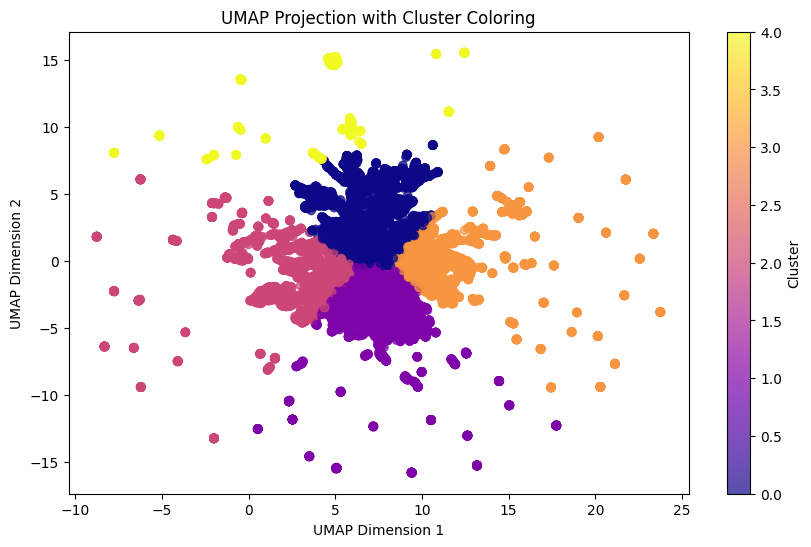

In [178]:
#plt.figure(figsize=(10, 6))
#plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c= umap_df['Cluster'], cmap='plasma', alpha=0.7)  # Color by 'Cluster'
#plt.colorbar(label='Cluster')
#plt.xlabel('UMAP Dimension 1')
#plt.ylabel('UMAP Dimension 2')
#plt.title('UMAP Projection with Cluster Coloring')
#plt.show()


In [213]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import umap

n_neighbors= [5, 10, 15, 20, 30]

def neighborhood_preservation_umap(X, n_neighbors=10, n_components=2):
    # Aplicar UMAP para reduzir dimensionalidade
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, random_state=42)
    X_low = reducer.fit_transform(X)
    
    # Configurar os modelos de vizinhos mais próximos para ambas as dimensões
    nbrs_high = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X)
    nbrs_low = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_low)
    
    # Obter os índices dos vizinhos para cada ponto
    neighbors_high = nbrs_high.kneighbors(X, return_distance=False)[:, 1:]  # ignorar o próprio ponto
    neighbors_low = nbrs_low.kneighbors(X_low, return_distance=False)[:, 1:] # ignorar o próprio ponto
    
    # Calcular a preservação de vizinhança
    preserved_neighbors = []
    for i in range(X.shape[0]):
        # Contar vizinhos em comum entre as dimensões
        preserved = len(set(neighbors_high[i]).intersection(neighbors_low[i]))
        preserved_neighbors.append(preserved / n_neighbors)  # normalizar pelo total de vizinhos
    
    # Retornar a média de preservação de vizinhança
    return np.mean(preserved_neighbors)

# Exemplo de uso com dados fictícios
X = features_scaled  # substitua com seus dados reais
preservacao_umap = neighborhood_preservation_umap(X)
print(f"Preservação de Vizinhança com UMAP: {preservacao_umap * 100:.2f}%")


Preservação de Vizinhança com UMAP: 34.45%


In [216]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import umap

def neighborhood_preservation_umap(X, n_neighbors_list, n_components=2):
    preservation_scores = {}
    
    for n_neighbors in n_neighbors_list:
        # Apply UMAP with the current number of neighbors
        reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, random_state=42)
        X_low = reducer.fit_transform(X)
        
        # Set up nearest neighbors models for high and low dimensions
        nbrs_high = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X)
        nbrs_low = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_low)
        
        # Get indices of neighbors for each point
        neighbors_high = nbrs_high.kneighbors(X, return_distance=False)[:, 1:]  # ignore the point itself
        neighbors_low = nbrs_low.kneighbors(X_low, return_distance=False)[:, 1:] # ignore the point itself
        
        # Calculate neighborhood preservation
        preserved_neighbors = []
        for i in range(X.shape[0]):
            preserved = len(set(neighbors_high[i]).intersection(neighbors_low[i]))
            preserved_neighbors.append(preserved / n_neighbors)  # normalize by number of neighbors
        
        # Average preservation score for this n_neighbors
        preservation_score = np.mean(preserved_neighbors)
        preservation_scores[n_neighbors] = preservation_score
        
        print(f"n_neighbors={n_neighbors}, Neighborhood Preservation: {preservation_score * 100:.2f}%")
    
    return preservation_scores

# Example of use
# X = np.random.rand(1000, 50)  # replace with your actual high-dimensional data
n_neighbors = [5, 10, 15, 20, 30]
X = features_scaled  # substitua com seus dados reais
preservation_scores = neighborhood_preservation_umap(X, n_neighbors)


n_neighbors=5, Neighborhood Preservation: 41.18%
n_neighbors=10, Neighborhood Preservation: 34.77%
n_neighbors=15, Neighborhood Preservation: 31.98%
n_neighbors=20, Neighborhood Preservation: 31.27%
n_neighbors=30, Neighborhood Preservation: 28.66%


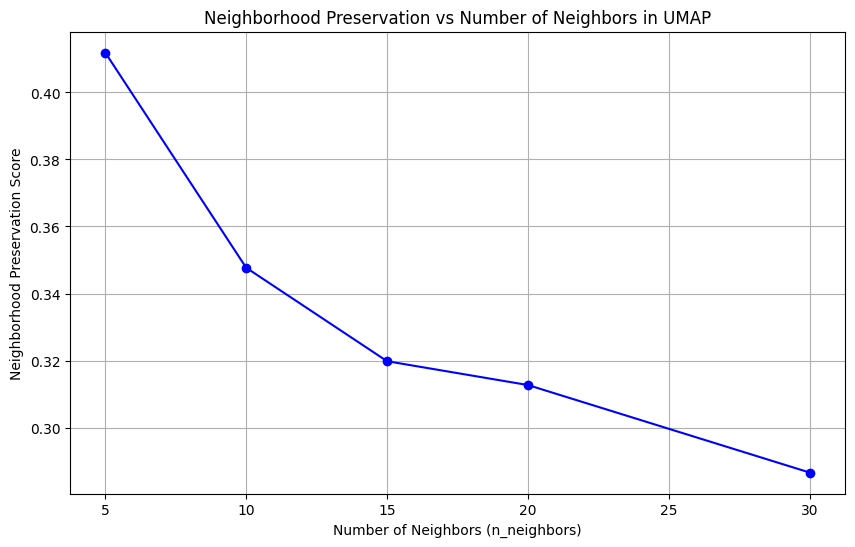

In [224]:
# Plotting the neighborhood preservation scores
plt.figure(figsize=(10, 6))
plt.plot(list(preservation_scores.keys()), list(preservation_scores.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Neighborhood Preservation Score')
plt.title('Neighborhood Preservation vs Number of Neighbors in UMAP')
plt.grid()
plt.show()

In [218]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import umap
import numpy as np

def silhouette_score_for_different_clusters(X, n_clusters_list, n_neighbors=15, n_components=2):
    scores = {}

    # Apply UMAP for dimensionality reduction
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, random_state=42)
    X_low = reducer.fit_transform(X)
    
    for n_clusters in n_clusters_list:
        # Perform KMeans clustering for each n_clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_low)
        
        # Calculate silhouette score for the current number of clusters
        silhouette_avg = silhouette_score(X_low, cluster_labels)
        
        # Store the silhouette score
        scores[n_clusters] = silhouette_avg
        print(f"n_clusters={n_clusters}, Silhouette Score: {silhouette_avg:.4f}")
    
    return scores

# Example of usage
# X = np.random.rand(1000, 50)  # replace with your high-dimensional data
n_clusters = [3, 5, 10, 15, 20, 30]
scores = silhouette_score_for_different_clusters(X, n_clusters)


n_clusters=3, Silhouette Score: 0.3100
n_clusters=5, Silhouette Score: 0.3855
n_clusters=10, Silhouette Score: 0.3928
n_clusters=15, Silhouette Score: 0.3822
n_clusters=20, Silhouette Score: 0.3865
n_clusters=30, Silhouette Score: 0.3958


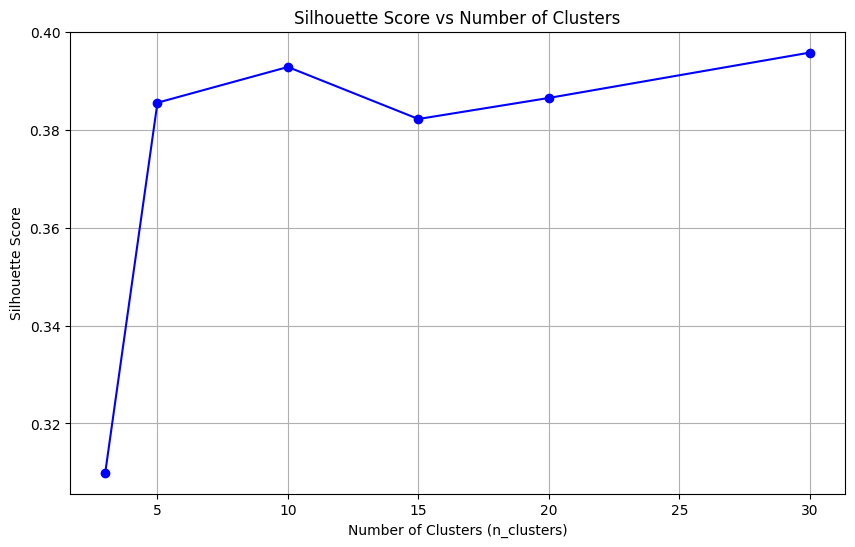

In [220]:
plt.figure(figsize=(10, 6))
plt.plot(list(scores.keys()), list(scores.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid()
plt.show()

n_neighbors=5, Silhouette Score: 0.3408
n_neighbors=10, Silhouette Score: 0.3610
n_neighbors=15, Silhouette Score: 0.3887
n_neighbors=20, Silhouette Score: 0.3880
n_neighbors=30, Silhouette Score: 0.3977


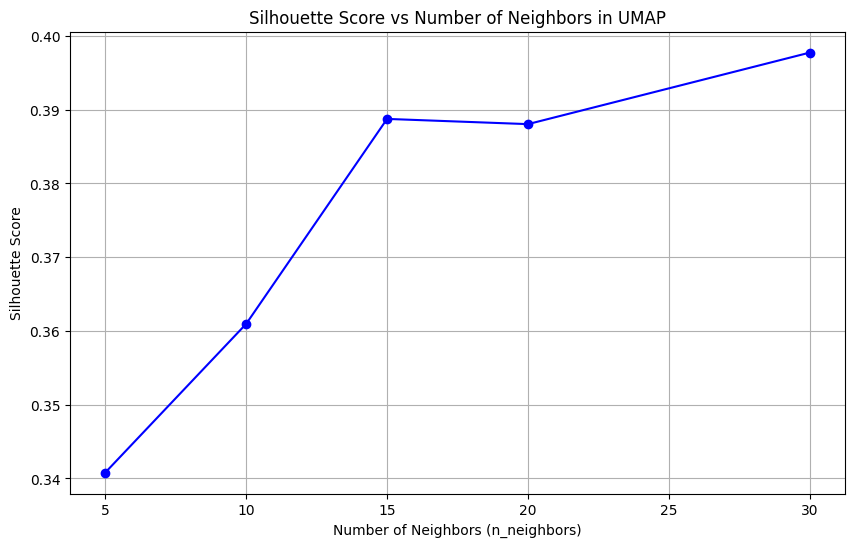

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

def silhouette_score_for_different_neighbors(X, n_neighbors_list, n_clusters, n_components=2):
    scores = {}
    
    for n_neighbors in n_neighbors_list:
        # Apply UMAP with the current number of neighbors
        reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, random_state=42)
        X_low = reducer.fit_transform(X)
        
        # Perform KMeans clustering on the UMAP-reduced data
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_low)
        
        # Calculate the silhouette score for the current configuration
        silhouette_avg = silhouette_score(X_low, cluster_labels)
        
        # Store the silhouette score
        scores[n_neighbors] = silhouette_avg
        print(f"n_neighbors={n_neighbors}, Silhouette Score: {silhouette_avg:.4f}")
    
    return scores

# Example usage
# X = np.random.rand(1000, 50)  # replace with your high-dimensional data
n_neighbors = [5, 10, 15, 20, 30]
X = features_scaled
n_clusters = 10 # specify the number of clusters for silhouette score
scores = silhouette_score_for_different_neighbors(X, n_neighbors, n_clusters)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(list(scores.keys()), list(scores.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Neighbors in UMAP')
plt.grid()
plt.show()
